In [1]:
]activate ..

In [2]:
using Apophis

┌ Info: Precompiling Apophis [b41c07a2-2abb-11e9-070a-c3c1b239e7df]
└ @ Base loading.jl:1186


length(methods(RNp1BP_pN_A_J234E_J2S_ng!)) = 1
length(methods(TaylorIntegration.jetcoeffs!)) = 3
methods(RNp1BP_pN_A_J234E_J2S_ng!) = # 1 method for generic function "RNp1BP_pN_A_J234E_J2S_ng!":
[1] RNp1BP_pN_A_J234E_J2S_ng!(t, q, dq) in Apophis at /Users/Jorge/projects/Apophis/src/Apophis.jl:113
t0 == 2.4547335e6 = true


In [3]:
c_au_per_day

173.14468465358982

In [4]:
# using TaylorIntegration, LinearAlgebra # Apophis.jl @reexports TaylorIntegration and LinearAlgebra
using Plots, JLD, DelimitedFiles, Dates
using Statistics: mean, std

In [5]:
vars = ["tv_neodys_obs", "xv1", "tvS1", "xvS1", "gvS1"] #names of variables
for i in eachindex(vars)
    filename = string("Apophis_jt_", vars[i], ".jld")
    filename
    ex = Symbol(vars[i])
    @eval $ex = load($filename, vars[$i])

    #read solution from files and assign recovered variable to recovered_sol_i
    # recovered_sol_i = load(filename, vars[i])

    #check that solution was recovered succesfully
    # @show recovered_sol_i == sol[i]
end

tv_neodys_obs#, xv1, tvS1, xvS1, gvS1

xv1

In [6]:
sort(union(apophisdofs, ssdofs)) == collect(1:72)

true

xv1[2,apophisdofs]

xv1[2,sundofs]

xv1[20,ssdofs[end-6:end]]

In [7]:
# read NEODyS delay observations (range)
del = readdlm("../Apophis_NEODyS_DEL.dat")
#read NEODyS Doppler obs. (range-rate)
dop = readdlm("../Apophis_NEODyS_DOP.dat")
# read NEODyS delay & Doppler
deldop = readdlm("../Apophis_NEODyS.dat");

# retrieve times of delay observations
del_ind = 3:17
jd_del = Dates.datetime2julian.(  Dates.DateTime.( del[del_ind,3].*"T".*del[del_ind,4] )  )

# retrieve times of Doppler observations
dop_ind = 6:29
jd_dop = Dates.datetime2julian.(  Dates.DateTime.( dop[dop_ind,3].*"T".*dop[dop_ind,4] )  );

#check that all times in jd_dop are elements of tv_neodys_obs; do the same for jd_del
#for i in eachindex(jd_dop)
#    @show in(jd_dop[i], tv_neodys_obs)
#end
;

In [8]:
# check for each delay observation that transmitting station is the same as the receiving station (monostatic)
@show all(  Int.(del[:,12]) .== Int.(del[:,13])  )
# check for each Doppler observation that transmitting station is the same as the receiving station (monostatic)
@show all(  Int.(dop[:,12]) .== Int.(dop[:,13])  )

# If checks pass, then in order to compute the observer position, we should not worry about 

all(Int.(del[:, 12]) .== Int.(del[:, 13])) = true
all(Int.(dop[:, 12]) .== Int.(dop[:, 13])) = true


true

In [9]:
del_station = del[:, 12]
dop_station = dop[:, 12];

In [10]:
length(del_station), length(dop_station)

(17, 29)

Let $\vec R$ denote the geocentric position of the observing station, $\vec \rho$ the topocentric position of the asteroid relative to the same station,  $\vec r_\mathrm{a}$ the geocentric position of the asteroid and $\vec r_\mathrm{E}$ the geocentric position of the asteroid. Then we have

$$
\vec r_\mathrm{a} =\vec r_\mathrm{E} + \vec R + \vec \rho
$$

Thus, the instantaneous topocentric range $\rho = |\vec \rho|$ of the asteroid may be computed as

$$
\rho = |\vec r_\mathrm{a} - \vec r_\mathrm{E} - \vec R| = \sqrt{(x_\mathrm{a} - x_\mathrm{E} - X)^2+(y_\mathrm{a} - y_\mathrm{E} - Y)^2+(z_\mathrm{a} - z_\mathrm{E} - Z)^2}
$$

And the instantaneous range rate $\dot \rho$ may be computed as:

$$
\dot \rho = \frac{1}{\rho}\vec{\rho} \cdot \dot{\vec{\rho}}
$$

In [11]:
dop_neodys_obs_ind = findall(x->in(x, jd_dop), tv_neodys_obs);
del_neodys_obs_ind = findall(x->in(x, jd_del), tv_neodys_obs)

# check that all elements in jd_dop/jd_del were found in tv_neodys_obs
@show length(dop_neodys_obs_ind) == length(jd_dop)
@show length(del_neodys_obs_ind) == length(jd_del)

length(dop_neodys_obs_ind) == length(jd_dop) = true
length(del_neodys_obs_ind) == length(jd_del) = true


true

In [19]:
const ea = 4 #Earth's index
const N = 12 

# Apophis geocentric range, radial velocity
r(x) = sqrt( (x[3N-2]-x[3ea-2])^2+(x[3N-1]-x[3ea-1])^2+(x[3N]-x[3ea])^2 )
vr(x) = ( (x[3N-2]-x[3ea-2])*(x[6N-2]-x[3(N+ea)-2])+(x[3N-1]-x[3ea-1])*(x[6N-1]-x[3(N+ea)-1])+(x[3N]-x[3ea])*(x[6N]-x[3(N+ea)]) )/r(x)

# Apophis topocentric range, radial velocity
function r_topo(x, station_code, jd_utc)
    r_a = [x[3N-2], x[3N-1], x[3N]] # asteroid barycentric position (au)
    r_E = [x[3ea-2], x[3ea-1], x[3ea]] # Earth barycentric position (au)
    R_station = observer_position(station_code, jd_utc)/au # station geocentric position (au)
    rho_vec = r_a - r_E - R_station
    return sqrt( rho_vec[1]^2+rho_vec[2]^2+rho_vec[3]^2 )
end

function vr_topo(x, station_code, jd_utc)
    r_a = [x[3N-2], x[3N-1], x[3N]] # asteroid barycentric position (au)
    v_a = [x[6N-2], x[6N-1], x[6N]] # asteroid barycentric velocity (au/day)
    
    r_E = [x[3ea-2], x[3ea-1], x[3ea]] # Earth barycentric position (au)
    v_E = [x[3(N+ea)-2], x[3(N+ea)-1], x[3(N+ea)]] # Earth barycentric velocity (au/day)
    
    R_station_T1 = observer_position(station_code, Taylor1([jd_utc, one(jd_utc)], 1))/au # station geocentric position (Taylor1) (au)
    R_station = [R_station_T1[1][0], R_station_T1[2][0], R_station_T1[3][0]] # station geocentric position (au)
    V_station = [R_station_T1[1][1], R_station_T1[2][1], R_station_T1[3][1]] # station geocentric velocity (au/day)
    
    ρ_vec = r_a - r_E - R_station # \vec \rho
    ρvel_vec = v_a - v_E - V_station # \dot \vec \rho
    ρ = sqrt( ρ_vec[1]^2+ρ_vec[2]^2+ρ_vec[3]^2 )
    
    return dot(ρ_vec, ρvel_vec)/ρ
end

# x: Solar System + Apophis state at receiving time
# station_code: observing station identifier (MPC nomenclature)
# t: time of echo reception (UTC/TDB?) TODO: compute TDB-UTC difference at receiving and transmitting times
# f_T: transmitter frequency
function delay_doppler(x, station_code, t, f_T)
    # Compute Taylor expansion at receiving time
    t_r = Taylor1([t, one(t)], Apophis.order)
    x_r = Taylor1.(x, Apophis.order)
    dx_r = similar(x_r)
    @time TaylorIntegration.jetcoeffs!(Val(Apophis.RNp1BP_pN_A_J234E_J2S_ng!), t_r, x_r, dx_r)
    
    r_a = x_r[apophisdofs[1:3]] # asteroid barycentric position at receiving time (au)
    r_E = x_r[(3ea-2):3ea] # Earth barycentric position (au)
    R_station = observer_position(station_code, t_r)/au # station geocentric position (au)
    r_r = r_E + R_station # barycentric position of receiver (au)
    
    # down-leg iterarion
    # τ_D first approximation: Eq. (1) Yeomans et al. (1992)
    ρ_r_0 = r_a()-r_r()
    τ_D = sqrt(ρ_r_0[1]^2 + ρ_r_0[2]^2 + ρ_r_0[3]^2)/c_au_per_day # (days) -R_b/c, but delay is wrt asteroid Center
    # @show τ_D
    for i in 1:5
        # Eq. (3) Yeomans et al. (1992)
        ρ_r = r_a(-τ_D)-r_r()
        # Eq. (4) Yeomans et al. (1992)
        τ_D = sqrt(ρ_r[1]^2 + ρ_r[2]^2 + ρ_r[3]^2)/c_au_per_day # (days) -R_b/c (COM correction) + Δτ_D (relativistic, tropo, iono...)
        # @show τ_D
    end
    # @show τ_D
    # Eq. (2) Yeomans et al. (1992)
    t_b = -τ_D
    
    # up-leg iteration
    # τ_U first estimation: Eq. (5) Yeomans et al. (1992)
    τ_U = τ_D
    # @show τ_U
    for i in 1:5
        # Eq. (7) Yeomans et al. (1992)
        ρ_t = r_a(-τ_D)-r_r(-τ_U-τ_D)
        # Eq. (8) Yeomans et al. (1992)
        τ_U = sqrt(ρ_t[1]^2 + ρ_t[2]^2 + ρ_t[3]^2)/c_au_per_day # (days) -R_b/c (COM correction) + Δτ_U (relativistic, tropo, iono...)
        # @show τ_U
    end
    # @show τ_U
    # Eq. (6) Yeomans et al. (1992)
    t_t = t_b - τ_U

    
    v_a = x_r[apophisdofs[4:6]]
    v_E = x_r[(3(N+ea)-2):3(N+ea)]
    V_station = differentiate.(R_station)
    v_r = v_E + V_station
    # v_r is equivalent to differentiate.(r_r) except for last order terms
    # @show v_r 
    # @show differentiate.(r_r) # barycentric velocity of receiver (au)
    
    # Eq. (10) Yeomans et al. (1992)
    ρ_vec_dot_t = v_a(t_b)-v_r(t_t)
    ρ_vec_dot_r = v_a(t_b)-v_r()
    
    ρ_vec_t = r_a(t_b) - r_r(t_t)
    ρ_vec_r = r_a(t_b) - r_r()
    
    # Eq. (11) Yeomans et al. (1992)
    ρ_t = sqrt(ρ_vec_t[1]^2+ρ_vec_t[2]^2+ρ_vec_t[3]^2)
    ρ_dot_t = dot(ρ_vec_t, ρ_vec_dot_t)/ρ_t
    ρ_r = sqrt(ρ_vec_r[1]^2+ρ_vec_r[2]^2+ρ_vec_r[3]^2)
    ρ_dot_r = dot(ρ_vec_r, ρ_vec_dot_r)/ρ_r
    
    # @show ρ_dot_t
    # @show ρ_dot_r
    
    # Eq. (12) Yeomans et al. (1992)
    doppler1 = -f_T*(ρ_dot_t+ρ_dot_r)/c_au_per_day
    doppler2 = (ρ_dot_t/ρ_t)*dot(ρ_vec_t, v_r(t_t)) - (ρ_dot_r/ρ_r)*dot(ρ_vec_r, v_r()) - ρ_dot_t*ρ_dot_r
    r_s = x_r[sundofs[1:3]]
    r_ts = r_r(t_t) - r_s(t_t)
    r_rs = r_r() - r_s()
    factor = 1/sqrt(r_ts[1]^2+r_ts[2]^2+r_ts[3]^2) - 1/sqrt(r_rs[1]^2+r_rs[2]^2+r_rs[3]^2)
    doppler3 = μ[1]*factor
    doppler4 = (  dot(v_r(t_t), v_r(t_t)) - dot(v_r(), v_r())  )/2
    doppler_23 = -f_T*(doppler2 + doppler3 + doppler4)/(c_au_per_day^2)
    f_D = doppler1+doppler_23

    return τ_D + τ_U, f_D # total signal delay, TODO: + (TDB - UTC)_t - (TDB - UTC)_r
end

delay_doppler (generic function with 1 method)

In [20]:
tdelay, dshift = delay_doppler(  xv1[del_neodys_obs_ind[1], :], del_station[del_ind[1]], jd_del[1], 8560e6  )

  2.530240 seconds (15.07 M allocations: 1.220 GiB, 46.31% gc time)


( 0.0011884611349871452 - 3.825947266041621e-10 t + 2.0562922325261953e-17 t² + 7.142163371817425e-24 t³ + 2.1152234507510012e-30 t⁴ + 5.568232957829371e-37 t⁵ + 1.210673492356902e-43 t⁶ + 1.6601545131049541e-50 t⁷ - 1.9818516699304308e-57 t⁸ - 2.642736391952262e-63 t⁹ - 1.261191888585742e-69 t¹⁰ + 𝒪(t¹¹),  50602.21644886468 - 0.03237031053561464 t - 6.591163544213025e-9 t² - 1.7680400555129921e-15 t³ - 3.5133637297837113e-22 t⁴ - 8.719590793486745e-30 t⁵ + 3.577549067109592e-35 t⁶ + 2.264979906434231e-41 t⁷ + 9.397807083210708e-48 t⁸ + 2.9308477312526394e-54 t⁹ + 6.1600492477171416e-61 t¹⁰ + 𝒪(t¹¹))

In [21]:
1e6*86400*tdelay

 1.0268304206288934e8 - 33.0561843785996 t + 1.7766364889026327e-6 t² + 6.170829153250256e-13 t³ + 1.827553061448865e-19 t⁴ + 4.8109532755645767e-26 t⁵ + 1.0460218973963632e-32 t⁶ + 1.4343734993226804e-39 t⁷ - 1.7123198428198921e-46 t⁸ - 2.2833242426467546e-52 t⁹ - 1.089669791738081e-58 t¹⁰ + 𝒪(t¹¹)

In [22]:
1e6*86400*tdelay()-102682986.05

56.012889340519905

In [23]:
dshift

 50602.21644886468 - 0.03237031053561464 t - 6.591163544213025e-9 t² - 1.7680400555129921e-15 t³ - 3.5133637297837113e-22 t⁴ - 8.719590793486745e-30 t⁵ + 3.577549067109592e-35 t⁶ + 2.264979906434231e-41 t⁷ + 9.397807083210708e-48 t⁸ + 2.9308477312526394e-54 t⁹ + 6.1600492477171416e-61 t¹⁰ + 𝒪(t¹¹)

In [24]:
dshift()-57880.250

-7278.033551135319

In [262]:
# get range, rad vel values from integration

# tv_neodys_obs[del_neodys_obs_ind[1]]
rv1 = Array{Taylor1{Float64}}(undef, length(jd_del))
vrv1 = Array{Taylor1{Float64}}(undef, length(jd_dop))

for i in eachindex(del_neodys_obs_ind)
    #rv1[i] = r(  xv1[del_neodys_obs_ind[i], :]  )
    rv1[i] = r_topo(  xv1[del_neodys_obs_ind[i], :], del_station[del_ind[i]], jd_del[i]  )
end

for i in eachindex(dop_neodys_obs_ind)
    #vrv1[i] = vr(  xv1[dop_neodys_obs_ind[i], :]  )
    vrv1[i] = vr_topo(  xv1[dop_neodys_obs_ind[i], :], dop_station[dop_ind[i]], jd_dop[i]  )
end

In [263]:
# A2 = 0 residuals

# absolute
residual_r = (rv1()-del[del_ind,6]/au)# (au)
residual_vr = (vrv1()-dop[dop_ind,6]/au)# (au/day)

# relative
rel_res_r = residual_r ./ (del[del_ind,6]/au)
rel_res_vr = residual_vr ./ (dop[dop_ind,6]/au) #;

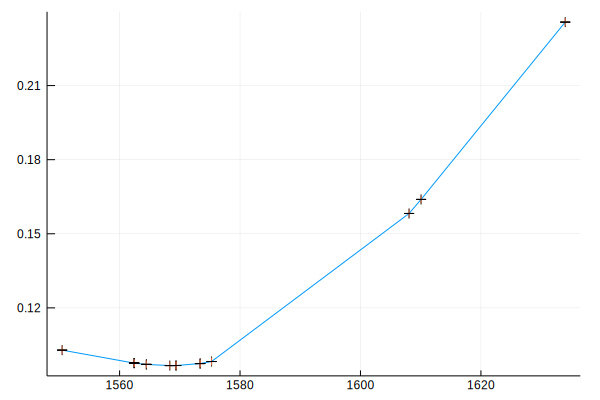

In [264]:
plot(tv_neodys_obs[del_neodys_obs_ind].-t0, rv1())
scatter!(tv_neodys_obs[del_neodys_obs_ind].-t0, del[del_ind,6]/au, yerror=del[del_ind,7]/au, leg=false, marker=:cross)

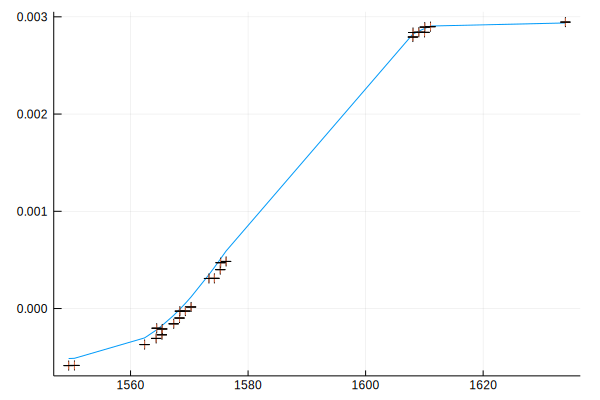

In [265]:
plot(tv_neodys_obs[dop_neodys_obs_ind].-t0, vrv1())
scatter!(tv_neodys_obs[dop_neodys_obs_ind].-t0, dop[dop_ind,6]/au, yerror=dop[dop_ind,7]/au, leg=false, marker=:cross)

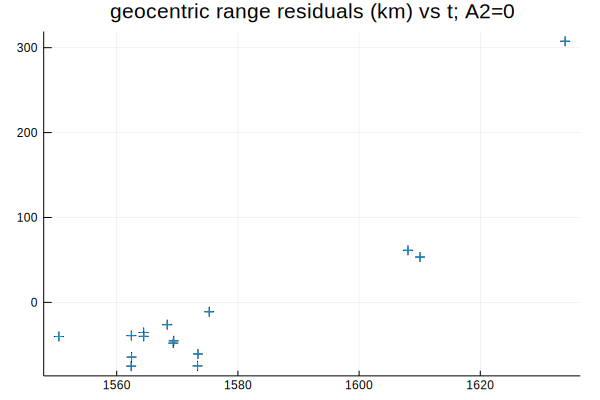

In [266]:
scatter(tv_neodys_obs[del_neodys_obs_ind].-t0, residual_r*au, leg=false, marker=:cross) #, yerror=del[del_ind,7]/au)
title!("geocentric range residuals (km) vs t; A2=0")
#ylims!(0,7000)

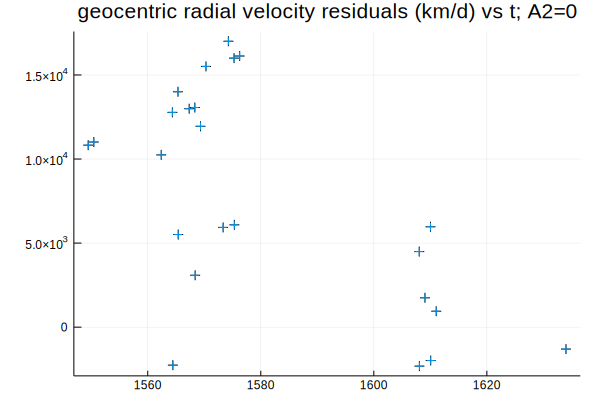

In [267]:
scatter(tv_neodys_obs[dop_neodys_obs_ind].-t0, residual_vr*au, leg=false, marker=:cross) #, yerror=dop[dop_ind,7]/au)
title!("geocentric radial velocity residuals (km/d) vs t; A2=0")

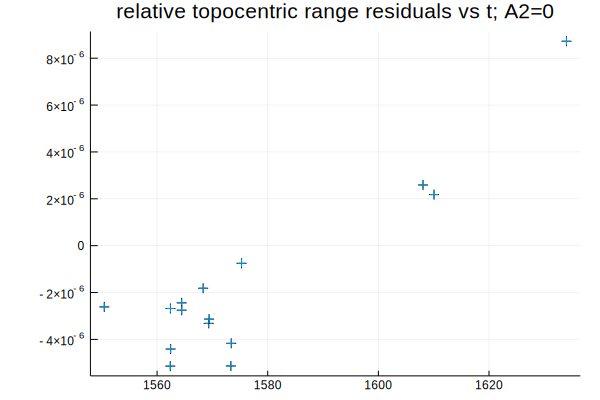

In [268]:
scatter(tv_neodys_obs[del_neodys_obs_ind].-t0, rel_res_r, leg=false, marker=:cross) #, yerror=del[del_ind,7]/au)
title!("relative topocentric range residuals vs t; A2=0")

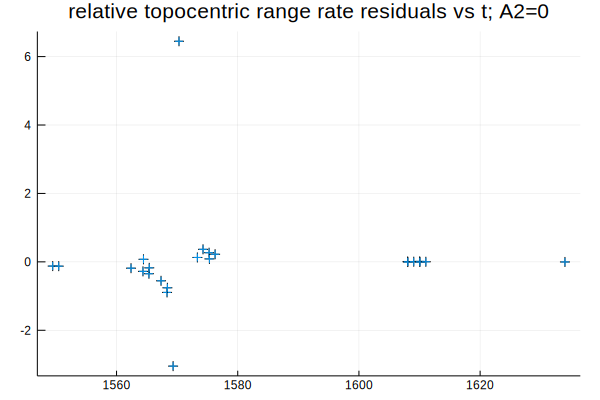

In [269]:
scatter(tv_neodys_obs[dop_neodys_obs_ind].-t0, rel_res_vr, leg=false, marker=:cross) #, yerror=del[del_ind,7]/au)
title!("relative topocentric range rate residuals vs t; A2=0")

In [270]:
rv1[1] # R(A2) = p(A2)

 0.10288755923819784 - 3.3121828843406894e-8 t + 1.780152067973864e-15 t² + 6.183132203463872e-22 t³ + 1.8311985101227656e-28 t⁴ + 4.82054946259289e-35 t⁵ + 1.0481082951439327e-41 t⁶ + 1.4372343100323983e-48 t⁷ - 1.715736231851138e-55 t⁸ - 2.287878895914546e-61 t⁹ - 1.0918433224465057e-67 t¹⁰ + 𝒪(t¹¹)

In [271]:
rv1[1]-constant_term(rv1[1]) # δR(A2) = R(A2) - R_obs = p(A2) - R_obs = p[1]*A2+p[2]*A2^2+... (p[0]=R_obs)

 - 3.3121828843406894e-8 t + 1.780152067973864e-15 t² + 6.183132203463872e-22 t³ + 1.8311985101227656e-28 t⁴ + 4.82054946259289e-35 t⁵ + 1.0481082951439327e-41 t⁶ + 1.4372343100323983e-48 t⁷ - 1.715736231851138e-55 t⁸ - 2.287878895914546e-61 t⁹ - 1.0918433224465057e-67 t¹⁰ + 𝒪(t¹¹)

In [272]:
inverse( rv1[1]-constant_term(rv1[1]) ) # A2(δR) = q(δR) = q[1]*δR+q[2]*δR^2+... (q[0]=0)

 - 3.019156957569558e7 t + 4.899076005298784e7 t² - 6.727404078863457e8 t³ + 9.406897585567703e9 t⁴ - 1.3879812811362115e11 t⁵ + 2.1360579122418118e12 t⁶ - 3.3994312460260617e13 t⁷ + 5.556447079123306e14 t⁸ - 9.279035291530056e15 t⁹ + 1.5768231044071712e17 t¹⁰ + 𝒪(t¹¹)

In [273]:
A2_δr_v = (  inverse.( rv1-rv1() )  ) # vector of A2(δr) polynomials at each delay observation;
A2_δvr_v = (  inverse.( vrv1-vrv1() )  ) # vector of A2(δvr) polynomials at each Doppler observation;

In [274]:
A2_del_v = map((x,y)->x(y), A2_δr_v, residual_r); # A2(δr) polynomials evaluated at the δr residuals;
A2_dop_v = map((x,y)->x(y), A2_δvr_v, residual_vr); # A2(δvr) polynomials evaluated at the δvr residuals;

In [275]:
A2_del_v

15-element Array{Float64,1}:
  8.116413262498027
 19.23652754800137 
 10.040275920155114
 16.542925722240494
  9.78500293790977 
 11.048014029536889
  8.699458363403124
 16.84692180721753 
 15.989310020887999
 35.55541268913958 
 29.05903063725698 
  6.411047755285393
 16.731247071954957
 13.87956836017623 
 57.52749931897711 

In [276]:
A2_dop_v

24-element Array{Float64,1}:
 241755.87178496536 
 214864.51164695452 
  78057.28523394532 
  87906.136828842   
 -15845.098277026398
  92004.4519993877  
  36545.15198710752 
  78851.97314891886 
  76471.23937118187 
  18220.116950448326
  67727.51062197667 
  85129.89239731095 
  30492.64532044967 
  85544.93719492284 
  79423.22212861445 
  30294.11308727102 
  79220.07908495964 
  46848.184706899505
 -23833.873170744748
  18797.212244882074
  67210.18945448635 
 -21980.671975272602
  10952.717357799367
 -29445.42322439023 

In [277]:
mean(A2_del_v), std(A2_del_v)

(18.364577029642703, 13.406285888551134)

In [278]:
mean(A2_dop_v), std(A2_dop_v)

(59800.515662662074, 65189.51957745179)

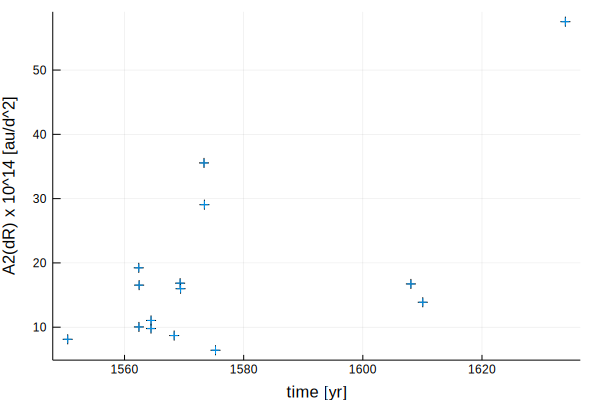

In [279]:
scatter(tv_neodys_obs[del_neodys_obs_ind].-t0, A2_del_v, leg=false, marker=:cross)
xlabel!("time [yr]")
ylabel!("A2(dR) x 10^14 [au/d^2]")

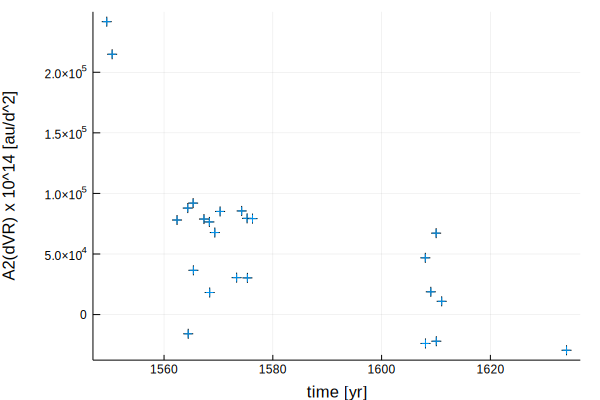

In [280]:
scatter(tv_neodys_obs[dop_neodys_obs_ind].-t0, A2_dop_v, leg=false, marker=:cross)
xlabel!("time [yr]")
ylabel!("A2(dVR) x 10^14 [au/d^2]")

In [281]:
using IntervalArithmetic

In [282]:
residual_r_interval = interval.(rv1()-(del[del_ind,6]+del[del_ind,7])/au, rv1()-(del[del_ind,6]-del[del_ind,7])/au)
residual_vr_interval = interval.(vrv1()-(dop[dop_ind,6]+dop[dop_ind,7])/au, vrv1()-(dop[dop_ind,6]-dop[dop_ind,7])/au);

In [283]:
A2_del_v_interval = map((x,y)->x(y), A2_δr_v, residual_r_interval); # A2(δr) polynomials evaluated at the δr residuals;
A2_dop_v_interval = map((x,y)->x(y), A2_δvr_v, residual_vr_interval); # A2(δvr) polynomials evaluated at the δvr residuals;

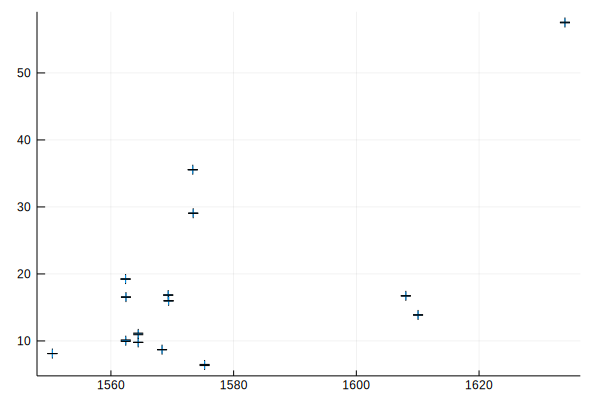

In [284]:
scatter(tv_neodys_obs[del_neodys_obs_ind].-t0, A2_del_v, yerror=radius.(A2_del_v_interval), leg=false, marker=:cross)

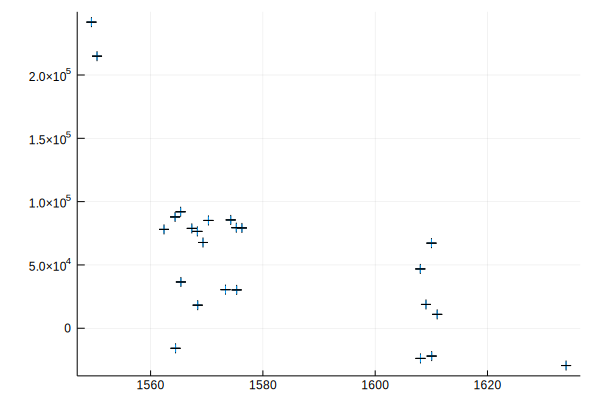

In [285]:
scatter(tv_neodys_obs[dop_neodys_obs_ind].-t0, A2_dop_v, yerror=radius.(A2_dop_v_interval), leg=false, marker=:cross)